In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
import os
os.path.abspath('USvideos.csv')
path = r"/home/jovyan/DATA1030/DATA1030-Project/data/USvideos.csv"

**Load Data set**

In [38]:
df = pd.read_csv(path)

**Adding Columns to Data**

In [39]:
print("Data Frame shape: ", df.shape)
# print(df.nunique())
print(df.dtypes)
# change catagory_id to catagory name
df['category_name'] = np.nan

df.loc[(df["category_id"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category_id"] == 10),"category_name"] = 'Music'
df.loc[(df["category_id"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category_id"] == 17),"category_name"] = 'Sport'
df.loc[(df["category_id"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category_id"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category_id"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category_id"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category_id"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category_id"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category_id"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category_id"] == 27),"category_name"] = 'Education'
df.loc[(df["category_id"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
df.loc[(df["category_id"] == 43),"category_name"] = 'Shows'

Data Frame shape:  (40949, 16)
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object


**Check missing values**

In [40]:
print(df.isnull().sum(axis=0)/df.shape[0])
print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])

video_id                  0.00000
trending_date             0.00000
title                     0.00000
channel_title             0.00000
category_id               0.00000
publish_time              0.00000
tags                      0.00000
views                     0.00000
likes                     0.00000
dislikes                  0.00000
comment_count             0.00000
thumbnail_link            0.00000
comments_disabled         0.00000
ratings_disabled          0.00000
video_error_or_removed    0.00000
description               0.01392
category_name             0.00000
dtype: float64
0.013919753840142617


In [41]:
# add more data based on current data set
df['like_rate'] =  df['likes'] / df['views'] * 100
df['dislike_rate'] =  df['dislikes']/df['views'] * 100
df['comment_log'] =  np.log10(df['comment_count'])
df['view_log'] = np.log10(df['views'])
df['interaction_rate'] = (df['likes'] + df['dislikes'] + 2 * df['comment_count'])/df['views'] * 100

In [42]:
df[['video_id','title', 'category_name','interaction_rate']].groupby('video_id').agg('max').sort_values(ascending = False, by = 'interaction_rate')
group_by_object = df.groupby('video_id').count().sort_values('trending_date', ascending = 'True').reset_index()
intermediate = group_by_object[['video_id','trending_date']]
intermediate.columns = ['video_id', 'total_trending_days']
df = pd.merge(df, intermediate, on='video_id', how='left')
df = df.groupby('video_id').agg('max', column= 'views')
df.shape

(6351, 21)

In [43]:
df[['title','views','category_name']].sort_values(by='views', ascending=False)[:10]

,title,views,category_name
video_id,,,
VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,225211923,Music
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,149376127,Entertainment
ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,148689896,Music
zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",139334502,Music
7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,123010920,Music
M4ZoCHID9GI,The Weeknd - Call Out My Name (Official Video),122544931,Music
TyHvyGVs42U,"Luis Fonsi, Demi Lovato - Échame La Culpa",102012605,Music
xTlNMmZKwpA,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...",94254507,Music
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,91933007,Entertainment


In [44]:
df[['title','views','category_name', 'interaction_rate']].sort_values(by='interaction_rate', ascending=False)[:10]

,title,views,category_name,interaction_rate
video_id,,,,
LsoLEjrDogU,Bruno Mars - Finesse (Remix) [Feat. Cardi B] [...,57951412,Music,36.571695
GnGPAYvve1A,#ProudToCreate: Pride 2018,1329391,Entertainment,35.407224
UaAHl_m_ybk,5 Seconds Of Summer - Want You Back (Audio),3738646,Music,33.786578
8O_MwlZ2dEg,j-hope 'Airplane' MV,12163782,Music,32.686585
TyHvyGVs42U,"Luis Fonsi, Demi Lovato - Échame La Culpa",102012605,Music,32.605121
JyUKqUTp9rc,NEW WET N WILD 'GOTH-O-GRAPHIC' COLLECTION | H...,2309169,How to and Style,30.364585
2E_HEeOpiEA,FULL FACE USING 7-ELEVEN MAKEUP!,1097258,How to and Style,30.078401
9vDdx1dba6c,dodie - Secret For The Mad,475702,Music,30.032525
inZzcTXYowY,Louis Tomlinson - Miss You (Official Video),3765264,Music,29.917911


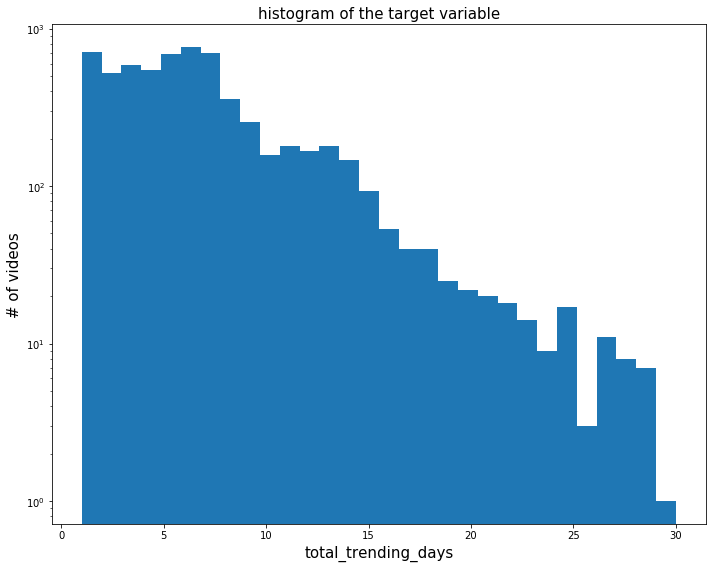

In [49]:
# histogram
plt.figure(figsize=(10,8))

# draw on the figure, define the properties of the line or marker
# plt.hist(y,bins=30,log=True)
df['total_trending_days'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('total_trending_days', fontsize = 15)
plt.ylabel('# of videos', fontsize = 15)
plt.title('histogram of the target variable', fontsize = 15)
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/y_hist.png',dpi=300)
plt.show()
# os.path.abspath('y_hist.png')

Entertainment               0.254763
Music                       0.126122
How to and Style            0.093529
Comedy                      0.085656
News and Politics           0.079515
People and Blogs            0.078255
Sport                       0.071170
Science and Technology      0.059991
Film and Animation          0.050071
Education                   0.039521
Pets and Animals            0.021886
Gaming                      0.016218
Cars and Vehicles           0.011022
Travel and Events           0.009447
Non Profits and Activism    0.002204
Shows                       0.000630
Name: category_name, dtype: float64


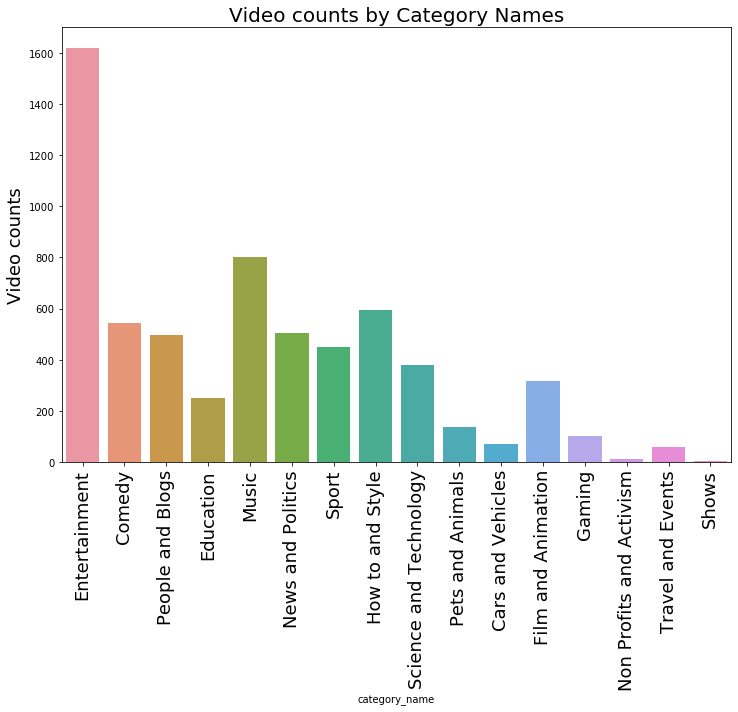

In [50]:
# which categories are easier to be trending videos

print(df['category_name'].value_counts()/df['category_name'].shape)
plt.figure(figsize=(12,8))
p = sns.countplot(data=df, x = 'category_name')
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 18)
plt.ylabel('Video counts', fontsize=18)
plt.title("Video counts by Category Names", fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/category_count.png',dpi=300, bbox_inches = 'tight')
plt.show()

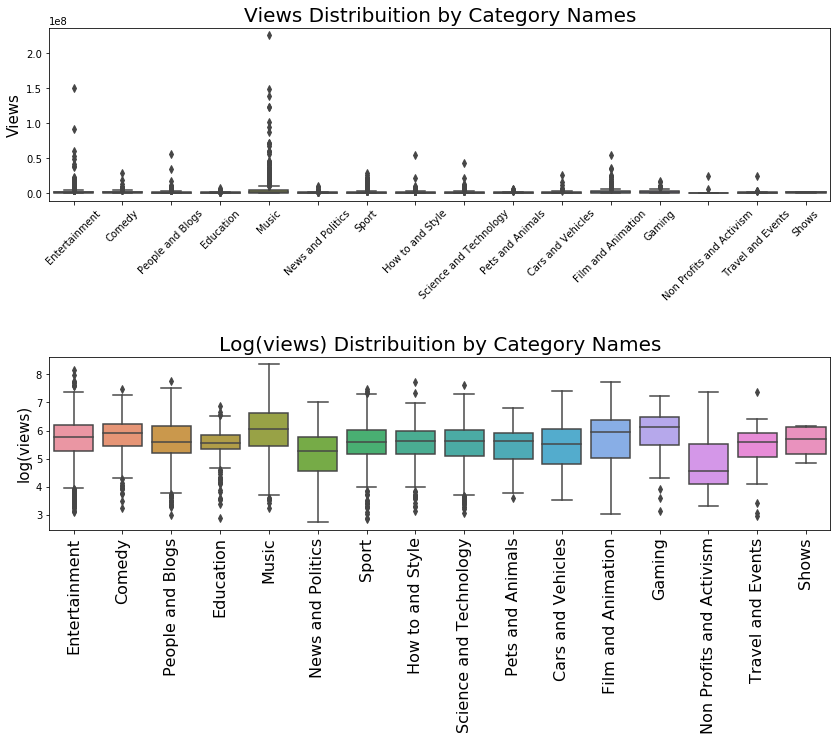

In [51]:
plt.figure(figsize = (14,9))
plt.subplot(211)
f2 = sns.boxplot(x='category_name', y='views', data=df)
f2.set_xticklabels(f2.get_xticklabels(),rotation=45)
f2.set_title("Views Distribuition by Category Names", fontsize=20)
f2.set_xlabel("", fontsize=15)
f2.set_ylabel("Views", fontsize=15)

plt.subplot(212)
f = sns.boxplot(x='category_name', y='view_log', data=df)
f.set_xticklabels(f.get_xticklabels(),rotation=90, fontsize = 16)
f.set_title("Log(views) Distribuition by Category Names", fontsize=20)
f.set_xlabel("", fontsize=15)
f.set_ylabel("log(views)", fontsize=15)

plt.subplots_adjust(hspace = 0.9, top = 0.9)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/view_category.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [53]:
# preprocess feature types one by one
# start machine learning 
num_ftrs = ['views', 'likes', 'dislikes', 'view_log','like_rate', 'dislike_rate', 'interaction_rate']
cat_ftrs = ['category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']

# one-hot encoder
ohe = OneHotEncoder(sparse=False)
si = SimpleImputer(strategy='constant',fill_value='missing')
cat_values = ohe.fit_transform(si.fit_transform(df[cat_ftrs]))
cat_ftr_names = ohe.get_feature_names()
df_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names)
# print(df_cat)

# standard scaler
ss = StandardScaler()
num_values = ss.fit_transform(df[num_ftrs])
df_num = pd.DataFrame(data=num_values,columns = num_ftrs)

df_preprocessed = pd.concat([df_cat,df_num],axis=1)
X = df_preprocessed
y = df['total_trending_days']
df_preprocessed['total_trending_days'] = y
export_csv = df_preprocessed.to_csv (r'/home/jovyan/DATA1030/DATA1030-Project/data/preprocessed.csv', index = None, header=True) 

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


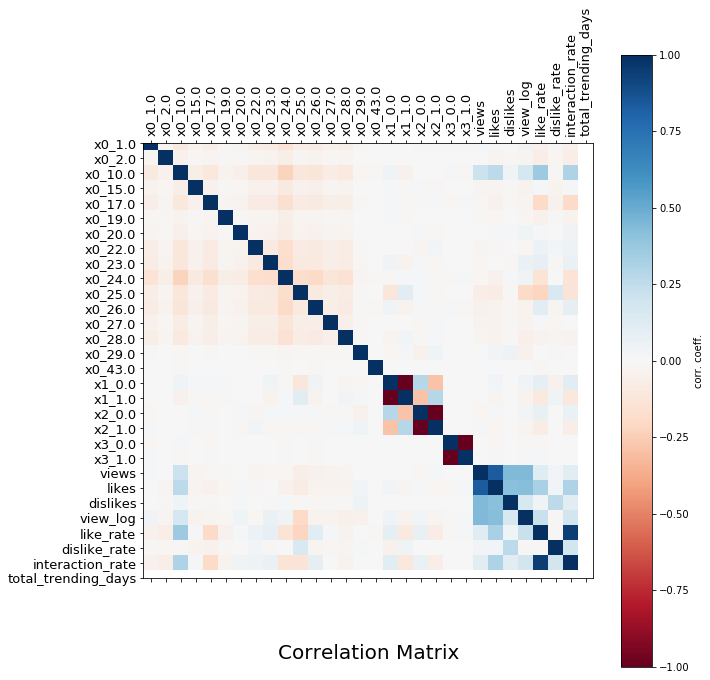

In [54]:
# correlation matrix
plt.figure(figsize=(10,10))
# plt.matshow(df.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.matshow(df_preprocessed.corr(),vmin=-1,vmax=1,cmap=plt.cm.RdBu,fignum=0)

plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns),rotation=90, fontsize = 13)
plt.yticks(np.arange(df_preprocessed.corr().shape[0]),list(df_preprocessed.corr().columns),fontsize = 13)
plt.tight_layout()
plt.title('Correlation Matrix', y=-0.2, fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/corr_coeff.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [55]:
print(y.describe())
ftr_names = X.columns

X_np = X.values
y_np = y.values

count    6351.000000
mean        6.447646
std         4.642806
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        30.000000
Name: total_trending_days, dtype: float64


**Model 1: Lasso**

In [26]:
def ML_pipeline_kfold_Lasso(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    
    best_alphas = []
    test_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # loop through 5 selected folders
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        
        # tune lasso hyper-parameter, alpha
        alpha = np.logspace(-5,-1,num=8)
        mse = []
        regs = []
        for a in alpha:
            reg = Lasso(alpha = a,max_iter = 1e4)
            reg.fit(X_train,y_train)
            mse.append(mean_squared_error(y_CV,reg.predict(X_CV)))
            regs.append(reg)
        # find the best alpha
        best_alphas.append(alpha[np.argmin(mse)])
        # grab the best model
        reg = regs[np.argmin(mse)]
        test_scores.append(reg.score(X_test, y_test))
    best_a = best_alphas[np.argmax(test_scores)]
    return best_a, min(mse), max(test_scores), reg

test_scores_lasso = []
regs_lasso = []
for i in range(10):
    best_a, best_mse, test_score, reg = ML_pipeline_kfold_Lasso(X_np,y_np,42*i,5)
    test_scores_lasso.append(test_score)
    regs_lasso.append(reg)
    print('Best alpha is {}. MSE is {}. Best score is {}'.format(best_a, best_mse, 
                                                                 max(test_scores_lasso)))
print('Lasso test scores:',np.around(np.mean(test_scores_lasso),2),'+/-',
      np.around(np.std(test_scores_lasso),2))

Best alpha is 0.026826957952797246. MSE is 16.700850224055543. Best score is 0.2044239680353922
Best alpha is 0.0019306977288832496. MSE is 16.421371413379674. Best score is 0.22965174498795582
Best alpha is 0.007196856730011514. MSE is 17.28135199713995. Best score is 0.22965174498795582
Best alpha is 0.0005179474679231213. MSE is 15.509607364137619. Best score is 0.2527992642974771
Best alpha is 0.007196856730011514. MSE is 15.840396825862957. Best score is 0.2527992642974771
Best alpha is 0.00013894954943731373. MSE is 16.93664893250989. Best score is 0.2527992642974771
Best alpha is 0.026826957952797246. MSE is 15.717408979088226. Best score is 0.2527992642974771
Best alpha is 0.0019306977288832496. MSE is 16.81214118877693. Best score is 0.2527992642974771
Best alpha is 0.026826957952797246. MSE is 16.514783985710892. Best score is 0.2527992642974771
Best alpha is 3.727593720314938e-05. MSE is 16.67538620941343. Best score is 0.2527992642974771
Lasso test scores: 0.22 +/- 0.02


**Model 2: random forest**

In [28]:
def ML_pipeline_kfold_rf(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    test_scores = []
#     best_pairs = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # loop through 5 selected folders
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        
        # tune random forest hyper-parameter, depth and min sample split
        depths = [i for i in range(1,15)]
        sss = [i for i in range(5,15)]
#         train_score = defaultdict(lambda: 0)
        mse = defaultdict(lambda: 0)
        regs = defaultdict(lambda: RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_split=2, random_state=random_state))
        for i,depth in enumerate(depths):
            for j,ss in enumerate(sss):
                reg = RandomForestRegressor(n_estimators=10, max_depth=depth, min_samples_split=ss, random_state=random_state)
                reg.fit(X_train, y_train)
#                 train_score[(i,j)] = mean_squared_error(y_train, reg.predict(X_train))
                mse[(i,j)] = mean_squared_error(y_CV, reg.predict(X_CV))
                regs[(i,j)] = reg
        # find the best alpha in this fold
        best_pair = min(mse, key=mse.get)
#         best_pairs.append(best_pair)
        best_depths = depths[best_pair[0]]
        best_sss = sss[best_pair[1]]
        # grab the best model
        reg = regs[best_pair]
#         CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(reg.score(X_test, y_test))
    return best_depths, best_sss, max(test_scores), min(mse.values()), reg

regs_rf = []
test_scores_rf = []
for i in range(10):
    best_depths, best_sss, test_score, mse, reg = ML_pipeline_kfold_rf(X_np,y_np,42*i,5)
#     CV_scores.append(CV_score)
    test_scores_rf.append(test_score)
    regs_rf.append(reg)
    print('Best depth is {}. Best sample split is {}. MSE is {}. Best score is {}'.format(
        best_depths, best_sss, mse, max(test_scores_rf)))
print('Random Forest test MSE:',np.around(np.mean(test_scores_rf),2),'+/-',np.around(np.std(test_scores_rf),2))

Best depth is 6. Best sample split is 8. MSE is 16.757838444483745. Best score is 0.19334664186726258
Best depth is 7. Best sample split is 10. MSE is 16.376371477301852. Best score is 0.23973479414972976
Best depth is 5. Best sample split is 5. MSE is 17.168730750907716. Best score is 0.23973479414972976
Best depth is 6. Best sample split is 6. MSE is 15.838842460197325. Best score is 0.2651316387677203
Best depth is 8. Best sample split is 13. MSE is 15.618592415432492. Best score is 0.2680904677285435
Best depth is 9. Best sample split is 11. MSE is 17.029946737596998. Best score is 0.2680904677285435
Best depth is 10. Best sample split is 14. MSE is 15.339991097410675. Best score is 0.2680904677285435
Best depth is 12. Best sample split is 9. MSE is 16.785678181876328. Best score is 0.2680904677285435
Best depth is 7. Best sample split is 14. MSE is 16.43284925238653. Best score is 0.2680904677285435
Best depth is 8. Best sample split is 8. MSE is 16.12850633948353. Best score is 0

In [29]:
globalp = regs_rf[np.argmax(test_scores_rf)]
print(globalp)
globalp.feature_importances_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=13,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=168, verbose=0,
                      warm_start=False)


array([6.13968768e-03, 3.70893576e-04, 5.41366225e-03, 3.86958939e-03,
       2.76536705e-03, 1.27586656e-04, 3.88765636e-03, 2.39110075e-03,
       2.96655872e-03, 1.85404212e-03, 4.67763737e-03, 8.10183862e-03,
       2.36958820e-03, 4.54034594e-03, 0.00000000e+00, 0.00000000e+00,
       6.76366998e-04, 4.84852288e-04, 9.86922540e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.09271210e-01, 2.61595037e-01,
       8.40653737e-02, 1.90120525e-01, 6.86109179e-02, 6.05177491e-02,
       7.50837203e-02])

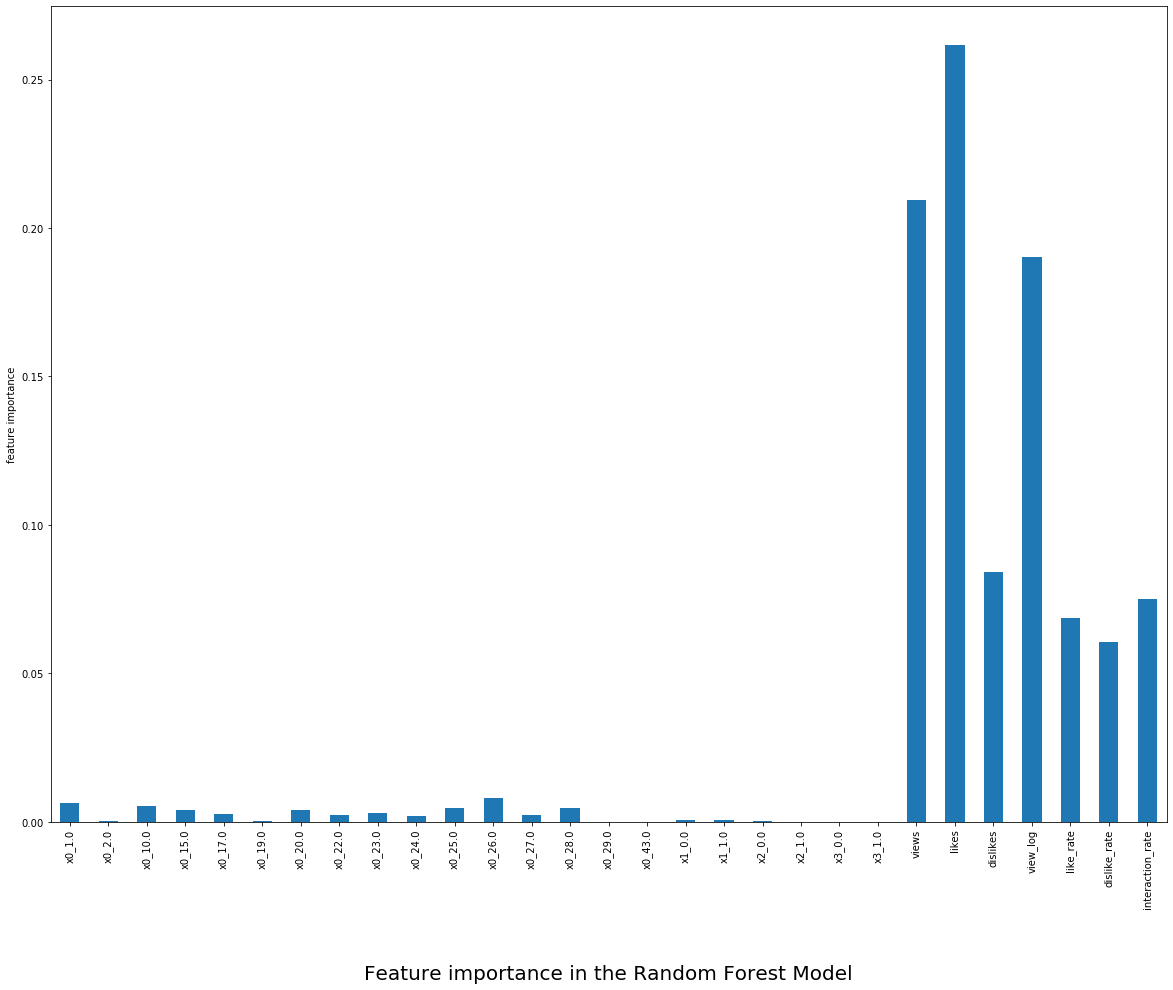

In [30]:
d = {'ftr_imp': globalp.feature_importances_}
pd.DataFrame(d, index=ftr_names).plot.bar(legend=None, figsize=(20, 15))
plt.ylabel('feature importance')
plt.title('Feature importance in the Random Forest Model', y=-0.2, fontsize=20)
plt.savefig('/home/jovyan/DATA1030/DATA1030-Project/figures/feature_impo.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [54]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [55]:
def ML_pipeline_xgb(X,y,random_state,n_folds):
    
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
#    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=random_state)
    CV_scores = []
    test_scores = []
    
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index], X_other.iloc[CV_index]
        y_train, y_CV = y_other.iloc[train_index], y_other.iloc[CV_index]
    
        data = []
        r2 = []
        max_depth = [1,3,5,7,9]
        sub_sample = [0.5, 0.6, 0.8, 1.0]
        gamma = [0, 1, 5]

        for i in max_depth:
            for j in sub_sample:
                for g in gamma:
                    
                    XGB = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.15, max_depth = i, 
                                               n_estimators = 100, subsample=j, gamma = g)
                    XGB.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_CV, y_CV)], verbose=False)
                    y_CV_pred = XGB.predict(X_CV)

                    data.append([i, j, g, XGB, r2_score(y_CV, y_CV_pred)])

        df3 = pd.DataFrame(data, columns = ['max_depth', 'sub_sample', 'gamma', 'model', 'cv_scores_xgb'])
        cv_best = max(df3['cv_scores_xgb'])
        index = np.argmax(np.array(df3['cv_scores_xgb']))
        pair_best = (df3['max_depth'][index],df3['sub_sample'][index],df3['gamma'][index])
        xgb = df3['model'][index]
        y_test_pred = xgb.predict(X_test)
        CV_scores.append(cv_best)
        r2.append(r2_score(y_test, y_test_pred))

    return CV_scores, r2, pair_best


test_scores_xgb = []

for i in range(1,6):
    CV_score, r2, pair_best = ML_pipeline_xgb(X,y,42*i,3)
    test_scores_xgb += r2
    print("The best max_depth and sub sample on the {}th round: {}".format(i, pair_best))
    # TODO 加gamma
print('test accuracy:',np.around(np.mean(test_scores_xgb),2), '+/-', np.around(np.std(test_scores_xgb),2))

The best max_depth and sub sample on the 1th round: (3, 0.5, 5)
The best max_depth and sub sample on the 2th round: (3, 0.8, 0)
The best max_depth and sub sample on the 3th round: (3, 0.8, 0)
The best max_depth and sub sample on the 4th round: (3, 0.3, 5)
The best max_depth and sub sample on the 5th round: (3, 0.8, 0)
test accuracy: 0.23 +/- 0.02


In [ ]:
# Train an SVR
def ML_pipeline_kfold_svr(X,y,random_state,n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    CV_scores = []
    test_scores = []
    kf = KFold(n_splits=n_folds, shuffle=True,random_state=random_state)
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]

        # tune svr hyper-parameter, gamma and c 
        gammas= np.logspace(-9, 3, 13)
        Cs = np.logspace(1, 10, 10)
#         train_score = defaultdict(lambda: 0)
        CV_score = defaultdict(lambda: 0)
        regs = defaultdict(lambda: SVR(gamma = 1, C = 1, probability=True, random_state=random_state))
        for i,gamma_value in enumerate(gammas):
            for j,c in enumerate(Cs):
                reg = SVR(gamma = gamma_value, C = c)
                reg.fit(X_train, y_train)
#                 train_score[(i,j)] = accuracy_score(y_train, reg.predict(X_train))
                CV_score[(i,j)] = mean_squared_error(y_CV, reg.predict(X_CV))
                regs[(i,j)] = reg
        # find the best alpha in this fold
        best_CV_pair = min(CV_score, key=CV_score.get)
        best_gamma = gammas[best_CV_pair[0]]
        best_c = Cs[best_CV_pair[1]]
        # grab the best model
        reg = regs[best_CV_pair]
        CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(reg.score(X_test, y_test))
    
#     print("best gamma is ", best_gamma)
#     print("best c is ", best_c)

    return best_gamma, best_c, min(CV_scores.values()), test_scores

test_scores_svr = []
for i in range(10):
    best_gamma, best_c, CV_scores, test_scores = ML_pipeline_kfold_svr(X,y,42*i,2)
    test_scores_svr.append(test_scores)
    print('Best gamma is {}. Best c is {}. MSE is {}. Best score is {}'.format(
        best_gamma, best_c, CV_scores, max(test_scores_svr)))
print("SVR best accuracy is ",np.around(np.mean(test_scores_svr),2), '+/-', np.around(np.std(test_scores_svr),2))